# Pipeline ETL de datos del csv

## Extracción y transformación de los datos

In [1]:
import pandas as pd

# Cargar el archivo CSV
csv_path = "food_ingredients_and_allergens.csv"
df = pd.read_csv(csv_path)

# --- LIMPIEZA BÁSICA ---

# 1. Eliminar filas duplicadas
df.drop_duplicates(inplace=True)

# 2. Eliminar filas completamente vacías
df.dropna(how='all', inplace=True)

# 3. Eliminar espacios extra en nombres de columnas
df.columns = df.columns.str.strip()

# 4. Rellenar con "None" valores que son NaN en columnas clave
df.fillna(value={"Sweetener": "None", "Fat/Oil": "None", "Seasoning": "None"}, inplace=True)

# 5. Eliminar filas sin 'Food Product' o 'Main Ingredient' (esas no tienen sentido)
df = df[~df['Food Product'].isna() & ~df['Main Ingredient'].isna()]

# --- FIN LIMPIEZA BÁSICA ---

# Paso 1: Quitar la última columna (Prediction)
df = df.iloc[:, :-1]

# Diccionario de clasificación de macronutrientes por ingrediente principal
macro_dict = {
    # proteínas
    'chicken': 'proteins', 'beef': 'proteins', 'egg': 'proteins', 'cheese': 'proteins',
    'lentil': 'proteins', 'tofu': 'proteins', 'milk': 'proteins', 'paneer': 'proteins',
    'shrimp': 'proteins', 'salmon': 'proteins', 'fish': 'proteins', 'lamb': 'proteins',

    # grasas
    'almonds': 'fats', 'butter': 'fats', 'oil': 'fats', 'avocado': 'fats',
    'peanut': 'fats', 'nuts': 'fats',

    # carbohidratos
    'sugar': 'carbohydrates', 'flour': 'carbohydrates', 'rice': 'carbohydrates',
    'bread': 'carbohydrates', 'noodle': 'carbohydrates', 'pasta': 'carbohydrates',
    'potato': 'carbohydrates', 'corn': 'carbohydrates', 'oats': 'carbohydrates',
    'quinoa': 'carbohydrates', 'pizza dough': 'carbohydrates',

    # frutas (puedes agrupar como carbohidratos si buscas energía rápida)
    'apple': 'carbohydrates', 'banana': 'carbohydrates', 'mango': 'carbohydrates',
    'strawberry': 'carbohydrates', 'berries': 'carbohydrates',

    # verduras
    'spinach': 'carbohydrates', 'tomato': 'carbohydrates', 'zucchini': 'carbohydrates',
    'onion': 'carbohydrates', 'lettuce': 'carbohydrates', 'pumpkin': 'carbohydrates',
    'mushroom': 'carbohydrates', 'vegetable': 'carbohydrates', 'chickpeas': 'carbohydrates'
}


# Normalizar ingredientes principales para búsqueda
def clasificar_macro(ingrediente):
    if pd.isna(ingrediente):
        return 'unknown'
    ing = ingrediente.lower()
    for clave in macro_dict:
        if clave in ing:
            return macro_dict[clave]
    return 'other'

df["Main Macro"] = df["Main Ingredient"].apply(clasificar_macro)

# Paso 3: Clasificación calórica (por sweetener y fat/oil)
def clasificar_calorico(row):
    sweetener = str(row['Sweetener']).lower()
    fat = str(row['Fat/Oil']).lower()
    score = 0
    if any(s in sweetener for s in ['sugar', 'honey', 'syrup']):
        score += 1
    if any(f in fat for f in ['butter', 'oil', 'lard']):
        score += 1
    if score == 2:
        return 'high'
    elif score == 1:
        return 'medium'
    else:
        return 'low'

df["Caloric"] = df.apply(clasificar_calorico, axis=1)


#Paso 4: Clasificación dietética
restricciones_dieta = {
    "vegetarian": [
        "chicken", "beef", "pork", "fish", "shrimp", "gelatin", "lamb", "ham"
    ],
    "vegan": [
        "chicken", "beef", "pork", "fish", "shrimp", "ham"
        "milk", "cheese", "egg", "honey", "butter", "yogurt", "lamb", "gelatin"
    ],
    "keto": [
        "sugar", "flour", "bread", "rice", "potato", "pasta",
        "banana", "mango", "corn", "oats", "quinoa", "cake", "pastry"
    ],
    "diabetic": [
        "sugar", "honey", "syrup", "flour", "white bread", "white rice",
        "cake", "jam", "pastry", "sweetened condensed milk", "cookies"
    ],
    "halal": [
        "pork", "bacon", "lard", "alcohol", "ham", "gelatin", "liqueur"
    ],
    "kosher": [
        "pork", "shrimp", "shellfish", "bacon", "lobster", "crab", "ham", "prawns", "lobster"
    ]
}

def detectar_dietas(row):
    dietas = []

    main_ingredient = str(row["Main Ingredient"]).lower()
    sweetener = str(row["Sweetener"]).lower()
    fat = str(row["Fat/Oil"]).lower()
    seasoning = str(row["Seasoning"]).lower()
    allergens = str(row["Allergens"]).lower()
    macro = str(row["Main Macro"]).lower()
    caloric = str(row["Caloric"]).lower()

    for dieta, prohibidos in restricciones_dieta.items():
        no_apto = False

        # Revisa cada campo individualmente
        for item in [main_ingredient, sweetener, fat, seasoning]:
            if any(p in item for p in prohibidos):
                no_apto = True
                break

        # Revisa alérgenos directamente (ideal para kosher, halal, sin lactosa, etc.)
        if not no_apto:
            if any(p.lower() in allergens for p in prohibidos):
                no_apto = True

        # Reglas específicas
        if dieta == "diabetic" and macro == "carbohydrates" and caloric == "high":
            no_apto = True

        if dieta == "keto" and macro == "carbohydrates":
            no_apto = True

        if not no_apto:
            dietas.append(dieta)

    return ", ".join(dietas)



df["Diets"] = df.apply(detectar_dietas, axis=1)


# Exportar el csv preprocesado
df.to_csv("platos_preprocesados.csv", index=False)

# Mostrar las primeras filas
df.head()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Main Macro,Caloric,Diets
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",fats,high,"vegetarian, halal, kosher"
2,Chicken Noodle Soup,Chicken broth,None,None,Salt,"Chicken, Wheat, Celery",proteins,low,"keto, diabetic, halal, kosher"
4,Cheddar Cheese,Cheese,None,None,Salt,Dairy,proteins,low,"vegetarian, keto, diabetic, halal, kosher"
5,Ranch Dressing,Buttermilk,Sugar,Vegetable oil,"Garlic, herbs",Dairy,proteins,high,"vegetarian, halal, kosher"
6,Caramel Popcorn,Popcorn,Sugar,Butter,Salt,Dairy,carbohydrates,high,"vegetarian, halal, kosher"


## Visualización de los datos


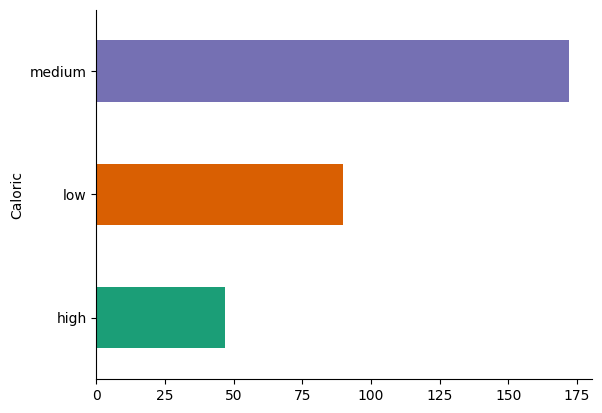

In [4]:
# @title Caloric

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Caloric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

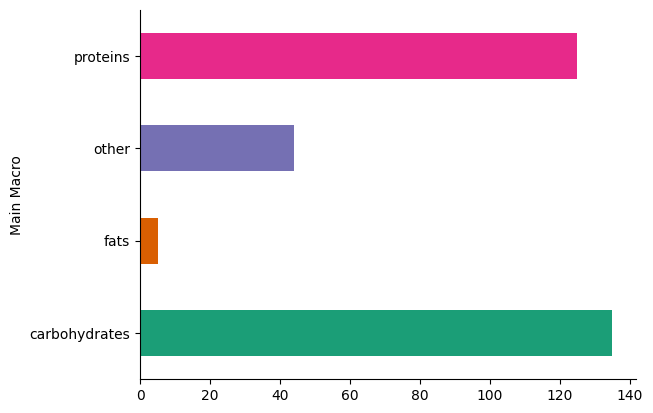

In [5]:
# @title Main Macro

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Main Macro').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Carga en la BD Neo4j


In [7]:
from neo4j import GraphDatabase

URI = "bolt://localhost:7687"
USER = "neo4j"
PASSWORD = "admin123"  # prueba con esta

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

# Probar conexión
with driver.session() as session:
    result = session.run("RETURN 'Conexión exitosa' AS mensaje")
    print(result.single()["mensaje"])

Conexión exitosa


In [2]:
import pandas as pd

df = pd.read_csv("platos_preprocesados.csv")


In [3]:
def insert_meals(tx, row):
    # Create Meal node
    tx.run("""
        MERGE (m:Meal {name: $name})
        SET m.macro = $macro, m.caloric = $caloric
    """, name=row["Food Product"], macro=row["Main Macro"], caloric=row["Caloric"])

    # Ingredients (handling comma-separated multiple values)
    for col in ["Main Ingredient", "Sweetener", "Fat/Oil", "Seasoning"]:
        if pd.notna(row[col]):
            ingredients = [ing.strip() for ing in str(row[col]).split(",") if ing.strip() and ing.strip().lower() != "none"]
            for ing in ingredients:
                tx.run("""
                    MERGE (i:Ingredient {name: toLower($ing)})
                    MERGE (m:Meal {name: $name})
                    MERGE (m)-[:CONTAINS_INGREDIENT]->(i)
                """, ing=ing, name=row["Food Product"])

    # Allergens (now associated directly to meals)
    if pd.notna(row["Allergens"]):
        for allergen in map(str.strip, row["Allergens"].split(",")):
            if allergen and allergen.lower() != "none":
                tx.run("""
                    MERGE (a:Allergen {name: toLower($al)})
                    MERGE (m:Meal {name: $meal})
                    MERGE (m)-[:CONTAINS_ALLERGEN]->(a)
                """, al=allergen, meal=row["Food Product"])

    # Diets
    if pd.notna(row["Diets"]):
        for diet in map(str.strip, row["Diets"].split(",")):
            if diet and diet.lower() != "none":
                tx.run("""
                    MERGE (d:Diet {name: toLower($diet)})
                    MERGE (m:Meal {name: $name})
                    MERGE (m)-[:SUITABLE_FOR]->(d)
                """, diet=diet, name=row["Food Product"])

                

In [4]:
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_meals, row)
        

/tmp/ipykernel_22897/2464265133.py:3: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_meals, row)


## 3. Centralidad de ingredientes

En el tercer minado nos centramos en identificar los ingredientes más relevantes dentro de la red de recetas. Para ello, aplicamos el algoritmo PageRank sobre el grafo bipartito de platos e ingredientes (tipo de grafo en el que los elementos de un mismo tipo no se pueden relacionar entre sí). Este análisis permite detectar cuáles son los ingredientes más influyentes, no solo por su frecuencia, sino también por aparecer en recetas que a su vez están conectadas con otros ingredientes importantes. El resultado se representó con un gráfico de barras que muestra los ingredientes más centrales del ecosistema culinario.

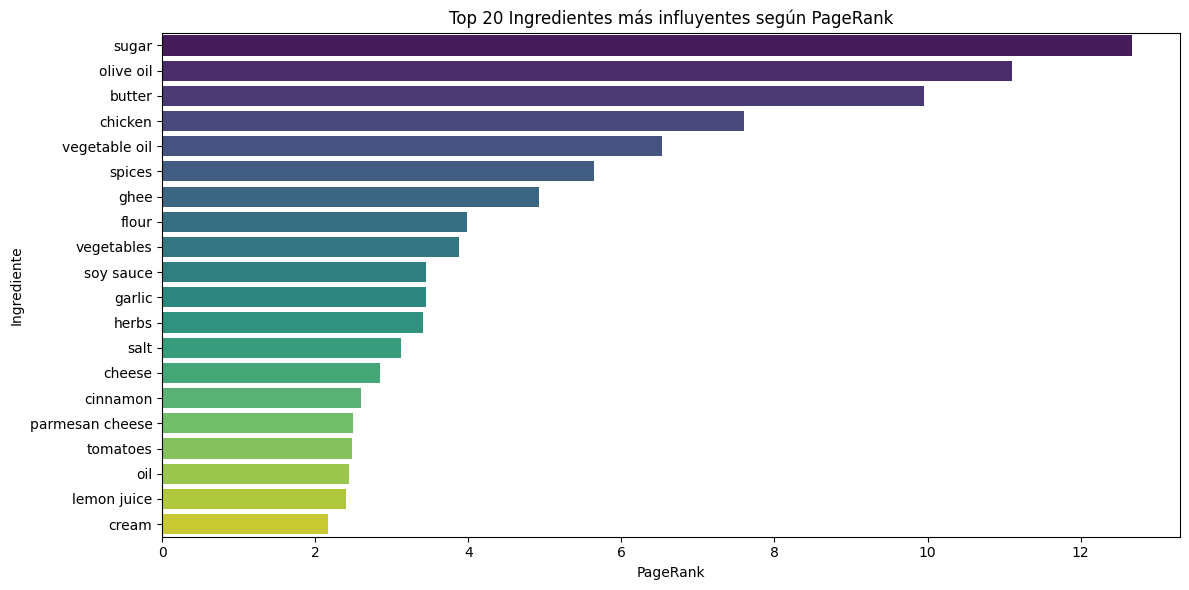

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase

# Conexión con Neo4j
driver = GraphDatabase.driver("bolt://localhost:7689", auth=("neo4j", "admin123"))

# Consulta Cypher para obtener PageRank de ingredientes
query = """
MATCH (i:Ingredient)
WHERE i.pagerank IS NOT NULL
RETURN i.name AS ingredient, i.pagerank AS score
ORDER BY score DESC
LIMIT 20
"""

# Ejecutar y cargar en DataFrame
with driver.session() as session:
    result = session.run(query)
    data = [record.data() for record in result]
df = pd.DataFrame(data)

# Visualizar con seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="score", y="ingredient", data=df, palette="viridis", legend=False, hue="ingredient")
plt.xlabel("PageRank")
plt.ylabel("Ingrediente")
plt.title("Top 20 Ingredientes más influyentes según PageRank")
plt.tight_layout()
plt.show()
